In [68]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [69]:
df = pd.read_csv("processminer-rare-event-mts - data.csv")
print(df.head())
print(df.shape)


          time  y        x1        x2        x3         x4        x5  \
0  5/1/99 0:00  0  0.376665 -4.596435 -4.095756  13.497687 -0.118830   
1  5/1/99 0:02  0  0.475720 -4.542502 -4.018359  16.230659 -0.128733   
2  5/1/99 0:04  0  0.363848 -4.681394 -4.353147  14.127998 -0.138636   
3  5/1/99 0:06  0  0.301590 -4.758934 -4.023612  13.161567 -0.148142   
4  5/1/99 0:08  0  0.265578 -4.749928 -4.333150  15.267340 -0.155314   

          x6        x7        x8  ...        x52       x53       x54  \
0 -20.669883  0.000732 -0.061114  ...  10.091721  0.053279 -4.936434   
1 -18.758079  0.000732 -0.061114  ...  10.095871  0.062801 -4.937179   
2 -17.836632  0.010803 -0.061114  ...  10.100265  0.072322 -4.937924   
3 -18.517601  0.002075 -0.061114  ...  10.104660  0.081600 -4.938669   
4 -17.505913  0.000732 -0.061114  ...  10.109054  0.091121 -4.939414   

         x55        x56       x57       x58       x59       x60  x61  
0 -24.590146  18.515436  3.473400  0.033444  0.953219  0.006076

In [3]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [4]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


In [9]:
# Remove time column, and the categorical columns
df = df.drop(['time','x28', 'x61'], axis=1)


In [10]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT,random_state=SEED )
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT,random_state=SEED)



In [11]:
df_train_0 = df_train.loc[df['y'] == 0]
print(df_train_0)


       y        x1         x2         x3          x4        x5         x6  \
6773   0  0.673712  -0.128276  -1.453604 -182.969410 -0.039561  42.420449   
58     0  0.302811  -4.799058  -3.237085   65.633460 -0.060755  20.620705   
6369   0  1.026375   3.587730   0.450852 -226.145970 -0.480936 -50.061836   
165    0  0.223640  -4.794398  -1.949642   26.862678 -0.555323 -10.598839   
3639   0  0.058683   9.316053   9.934855 -141.986030  0.321004 -41.042518   
16360  0  0.402339   0.138587   2.934759   16.595039 -0.513285  36.823311   
16226  0  0.066366   0.072896  -0.218529  -13.952692  0.253561  25.934700   
15890  0  0.161510   2.645606   2.590191   -1.616326 -0.252390  42.599678   
7741   0 -0.418036   1.809503  -4.926619  238.859625 -0.330439  20.752785   
2441   0 -0.627015  -3.143354  -3.335194  -62.660150 -0.506831 -62.376060   
13518  0 -0.000746  14.492893   3.481840  104.569403  1.331823   5.772957   
1067   0 -0.940107  -0.357915   0.597790   11.949195 -0.510172  -2.539390   

In [12]:
df_train_1 = df_train.loc[df['y'] == 1]


In [13]:
df_train_0_x = df_train_0.drop(['y'], axis=1)
print(df_train_0_x)

df_train_1_x = df_train_1.drop(['y'], axis=1)

             x1         x2         x3          x4        x5         x6  \
6773   0.673712  -0.128276  -1.453604 -182.969410 -0.039561  42.420449   
58     0.302811  -4.799058  -3.237085   65.633460 -0.060755  20.620705   
6369   1.026375   3.587730   0.450852 -226.145970 -0.480936 -50.061836   
165    0.223640  -4.794398  -1.949642   26.862678 -0.555323 -10.598839   
3639   0.058683   9.316053   9.934855 -141.986030  0.321004 -41.042518   
16360  0.402339   0.138587   2.934759   16.595039 -0.513285  36.823311   
16226  0.066366   0.072896  -0.218529  -13.952692  0.253561  25.934700   
15890  0.161510   2.645606   2.590191   -1.616326 -0.252390  42.599678   
7741  -0.418036   1.809503  -4.926619  238.859625 -0.330439  20.752785   
2441  -0.627015  -3.143354  -3.335194  -62.660150 -0.506831 -62.376060   
13518 -0.000746  14.492893   3.481840  104.569403  1.331823   5.772957   
1067  -0.940107  -0.357915   0.597790   11.949195 -0.510172  -2.539390   
11870  0.607004   3.888912   1.958365 

In [14]:
df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)
df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [15]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [62]:
nb_epoch =200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
input_dim
encoding_dim = 64
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 59)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                3840      
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_41 (Dense)             (None, 59)                3835      
Total params: 12,923
Trainable params: 12,923
Non-trainable params: 0
_______________________________________________________

In [63]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 11697 samples, validate on 2926 samples
Epoch 1/200
11697/11697 [==============================] - 1s 63us/step - loss: 2.4995 - accuracy: 0.0733 - val_loss: 1.5776 - val_accuracy: 0.1203
Epoch 2/200
11697/11697 [==============================] - 0s 17us/step - loss: 1.0874 - accuracy: 0.1389 - val_loss: 0.8356 - val_accuracy: 0.1545
Epoch 3/200
11697/11697 [==============================] - 0s 17us/step - loss: 0.6411 - accuracy: 0.1864 - val_loss: 0.5886 - val_accuracy: 0.2307
Epoch 4/200
11697/11697 [==============================] - 0s 17us/step - loss: 0.4882 - accuracy: 0.2511 - val_loss: 0.4936 - val_accuracy: 0.2717
Epoch 5/200
11697/11697 [==============================] - 0s 18us/step - loss: 0.4228 - accuracy: 0.3021 - val_loss: 0.4406 - val_accuracy: 0.3233
Epoch 6/200
11697/11697 [==============================] - 0s 18us/step - loss: 0.3834 - accuracy: 0.3306 - val_loss: 0.4085 - val_accuracy: 0.3421
Epoch 7/200
11697/11697 [==============================] - 0s 1

Epoch 56/200
11697/11697 [==============================] - 0s 18us/step - loss: 0.1793 - accuracy: 0.5185 - val_loss: 0.2108 - val_accuracy: 0.5369
Epoch 57/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1784 - accuracy: 0.5144 - val_loss: 0.2039 - val_accuracy: 0.5284
Epoch 58/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1786 - accuracy: 0.5215 - val_loss: 0.2039 - val_accuracy: 0.5359
Epoch 59/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1766 - accuracy: 0.5274 - val_loss: 0.2047 - val_accuracy: 0.5232
Epoch 60/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1765 - accuracy: 0.5250 - val_loss: 0.1975 - val_accuracy: 0.5598
Epoch 61/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1765 - accuracy: 0.5268 - val_loss: 0.2062 - val_accuracy: 0.5290
Epoch 62/200
11697/11697 [==============================] - 0s 20us/step - loss: 0.1753 - accuracy: 0.5262

Epoch 111/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1511 - accuracy: 0.5768 - val_loss: 0.1675 - val_accuracy: 0.5848
Epoch 112/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1486 - accuracy: 0.5816 - val_loss: 0.1678 - val_accuracy: 0.5738
Epoch 113/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1500 - accuracy: 0.5771 - val_loss: 0.1657 - val_accuracy: 0.5865
Epoch 114/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1474 - accuracy: 0.5795 - val_loss: 0.1678 - val_accuracy: 0.5841
Epoch 115/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1483 - accuracy: 0.5774 - val_loss: 0.1683 - val_accuracy: 0.5820
Epoch 116/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1581 - accuracy: 0.5807 - val_loss: 0.1804 - val_accuracy: 0.5769
Epoch 117/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1526 - accuracy:

11697/11697 [==============================] - 0s 19us/step - loss: 0.1372 - accuracy: 0.5867 - val_loss: 0.1521 - val_accuracy: 0.5882
Epoch 166/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1363 - accuracy: 0.5884 - val_loss: 0.1509 - val_accuracy: 0.5960
Epoch 167/200
11697/11697 [==============================] - 0s 18us/step - loss: 0.1344 - accuracy: 0.5877 - val_loss: 0.1562 - val_accuracy: 0.5919
Epoch 168/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1361 - accuracy: 0.5862 - val_loss: 0.1568 - val_accuracy: 0.5813
Epoch 169/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1353 - accuracy: 0.5854 - val_loss: 0.1567 - val_accuracy: 0.5991
Epoch 170/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1365 - accuracy: 0.5876 - val_loss: 0.1617 - val_accuracy: 0.5933
Epoch 171/200
11697/11697 [==============================] - 0s 19us/step - loss: 0.1348 - accuracy: 0.5845 - val_

In [59]:
autoencoder = load_model('autoencoder_classifier.h5')

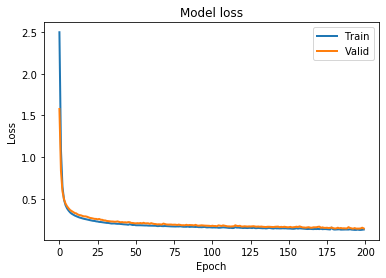

In [64]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

[0.09151894 0.09961602 0.0860611  ... 0.11067198 0.07326541 0.07633462] 2944


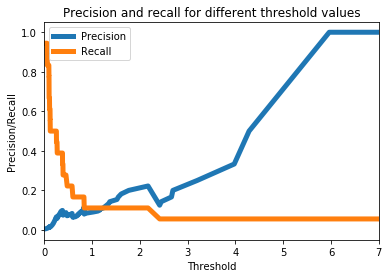

In [65]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})
print(mse,len(mse))

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.xlim(right=7)  # adjust the right leaving left unchanged
plt.xlim(left=0)
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [66]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

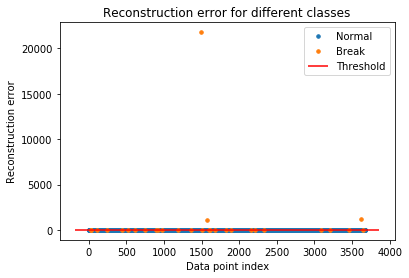

In [67]:
threshold_fixed = 0.8
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

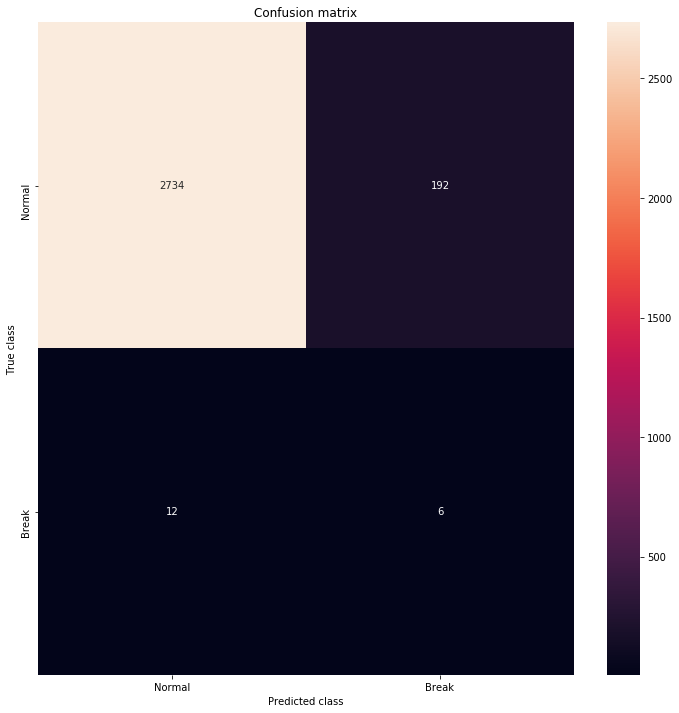

In [55]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

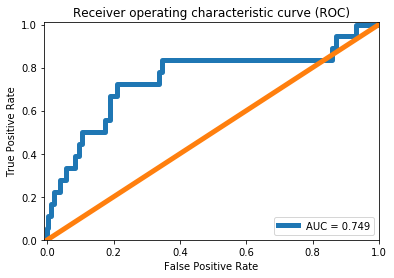

In [56]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
